# Notebook for running 1D-TDSE C code from Python
Author: Tadeas Nemec, 2023

### Load libraries and files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
### Main Python TDSE helper script, contains C structures, function wrappers etc.
from PythonTDSE import *

### Path to compiled dynamic C library
path_to_DLL = os.path.realpath(os.path.join(os.getcwd(), "build/libsingleTDSE.dylib"))

### TDSE DLL class declaration
DLL = TDSE_DLL(path_to_DLL)

### TDSE variables initialization

We instantiate a C-compatible ```inputs_def``` class that is in fact C types structure. This strucure (class) contains all the necessary variables for the C 1D-TDSE code. Then we initialize it from an HDF5 input file.

In [2]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def
filename = "results.h5"
inputs.init_inputs(filename)
inputs.init_prints(path_to_DLL)

Initialize temporal grid and initial field. There are two ways how to do it. Either you specify the result file from the CUPRAD code and select a particular field or you provide custom electric field and time grids.

In [3]:
### Set indeces in the field:
z_i = 75
r_i = 512
### Initialize field and time in the input
inputs.init_time_and_field(filename, z_i, r_i)

We can visualize and check the fields by plotting.

We use function ```ctype_arr_to_numpy``` for conversion of the Ctypes array into Numpy array.

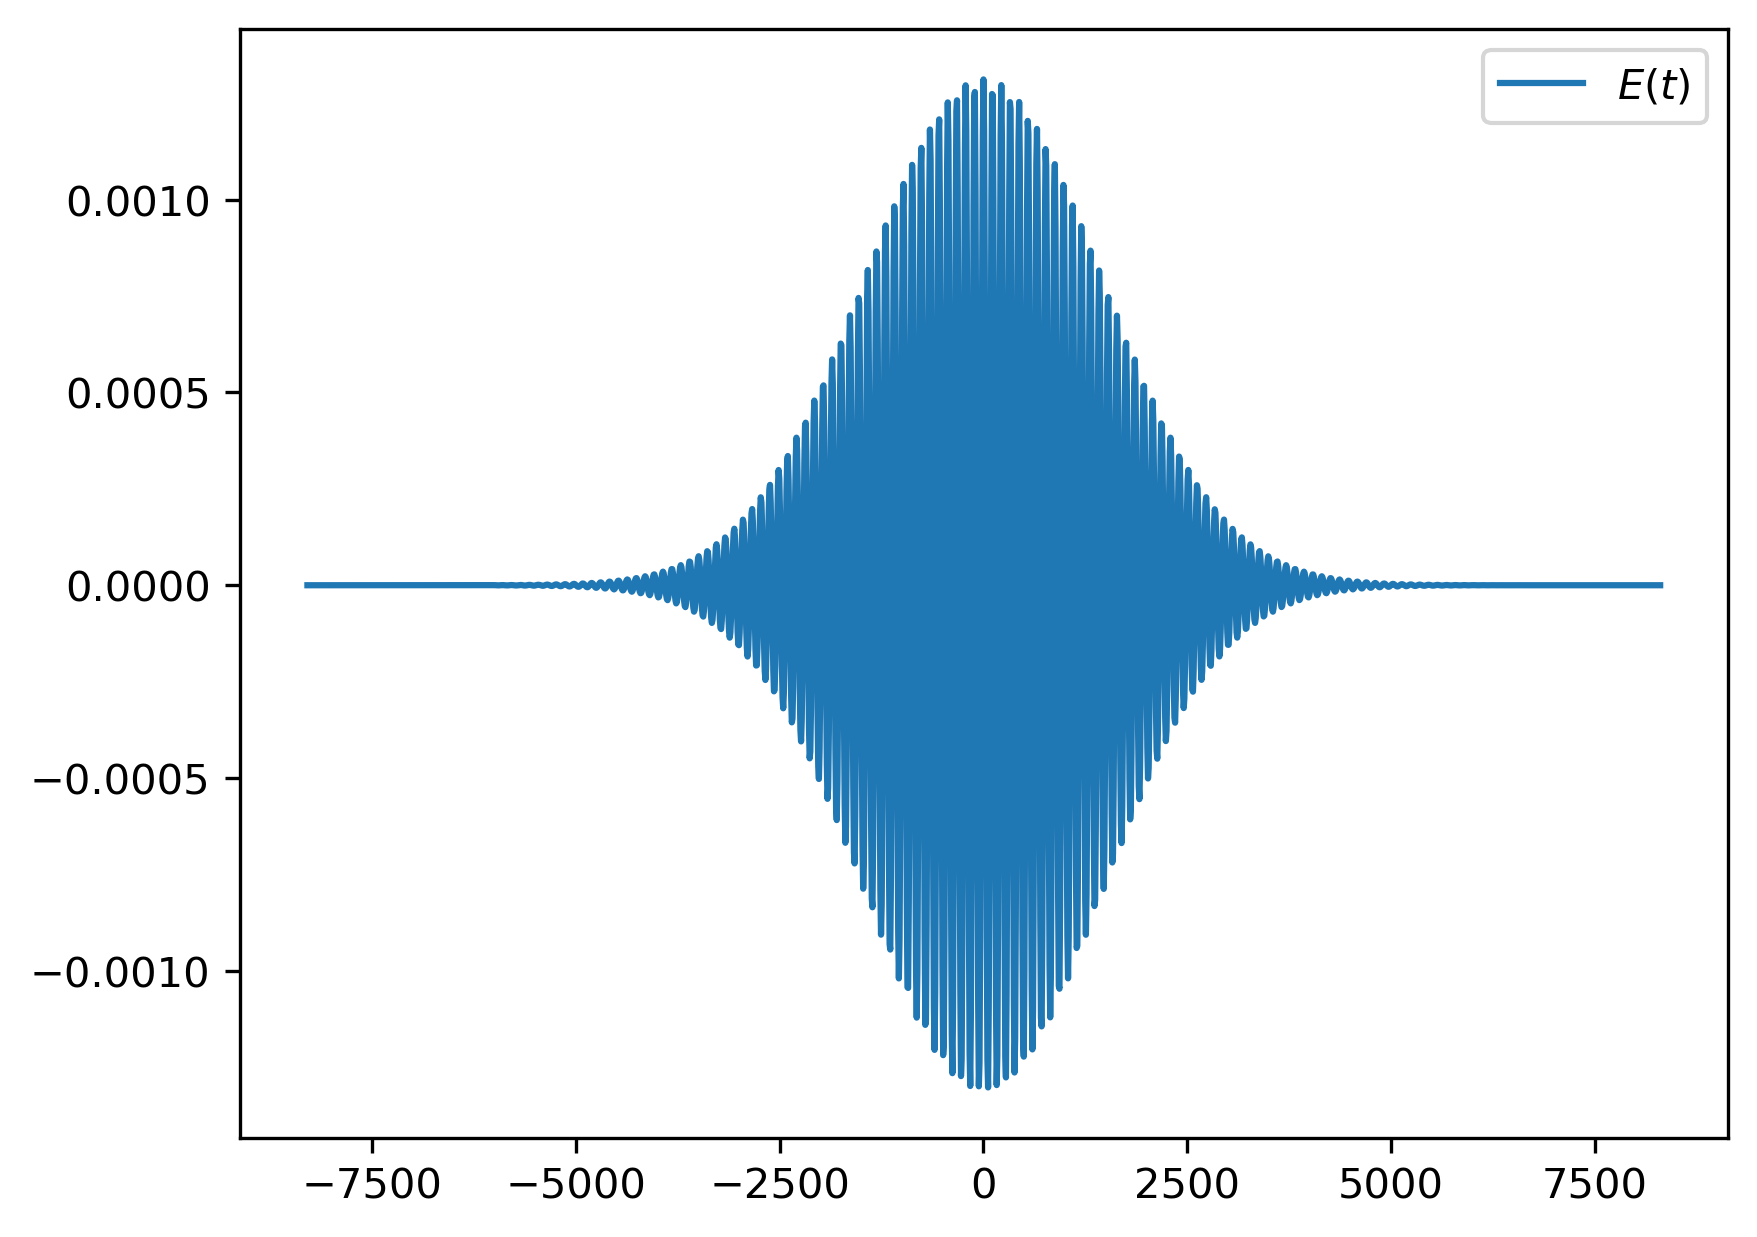

In [5]:
fig = plt.figure()
fig.dpi = 300
N = inputs.Efield.Nt
E = ctype_arr_to_numpy(inputs.Efield.Field, N)
t = ctype_arr_to_numpy(inputs.Efield.tgrid, N)
plt.plot(t, E, label = r"$E(t)$")
plt.legend()
plt.show()

### Ground state computation

We need to first compute the ground state (GS) wavefunction for the propagation. We call the C function ```Initialise_grid_and_ground_state``` and pass the pointer to ```inputs``` using Ctypes function ```byref```. This is conveniently encapsulated in the ```init_GS``` function. We need to include the path to the C library.

**Note**: it prints the progress of the GS energy computation.

In [6]:
DLL.init_GS(inputs)

We can check if the GS has been found by plotting it.

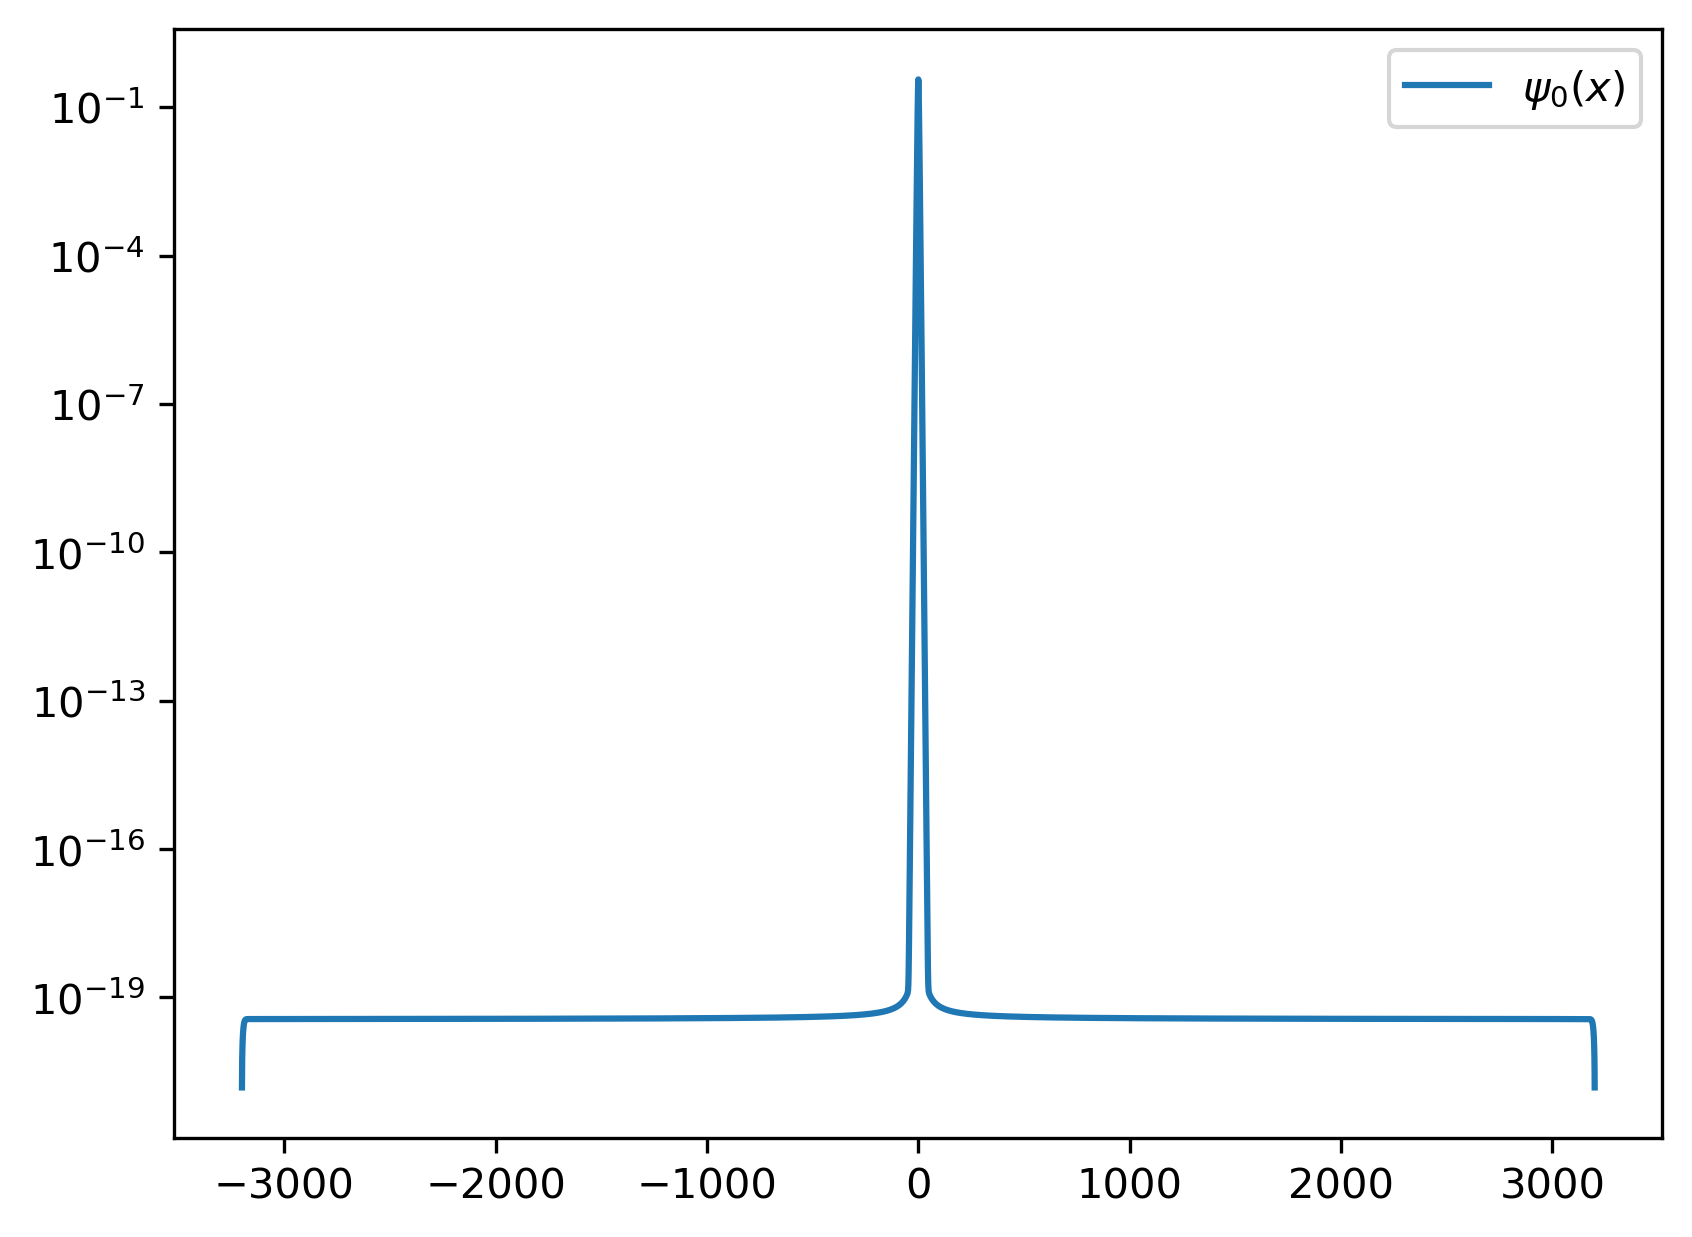

In [7]:
fig = plt.figure()
fig.dpi = 300
psi0 = ctype_arr_to_numpy(inputs.psi0, 2*(inputs.num_r+1))
x = ctype_arr_to_numpy(inputs.x, inputs.num_r+1)
plt.semilogy(x, np.abs(psi0)[0:-1:2], label = r"$\psi_0(x)$")
plt.legend()
plt.show()

### Propagation of the wavefunction

Now that we have found the GS, we can run the 1D-TDSE. We first define the output structure of type ```outputs_def``` that will store the result of the TDSE computation. 

**Remark**: This part of the code is computationally heavy and may take several minutes to finish, depending on the size of the input field. 

In [9]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

We may now plot the result of the computation. We can try plotting the expectation value of x, $<x(t)>$, during the propagation.

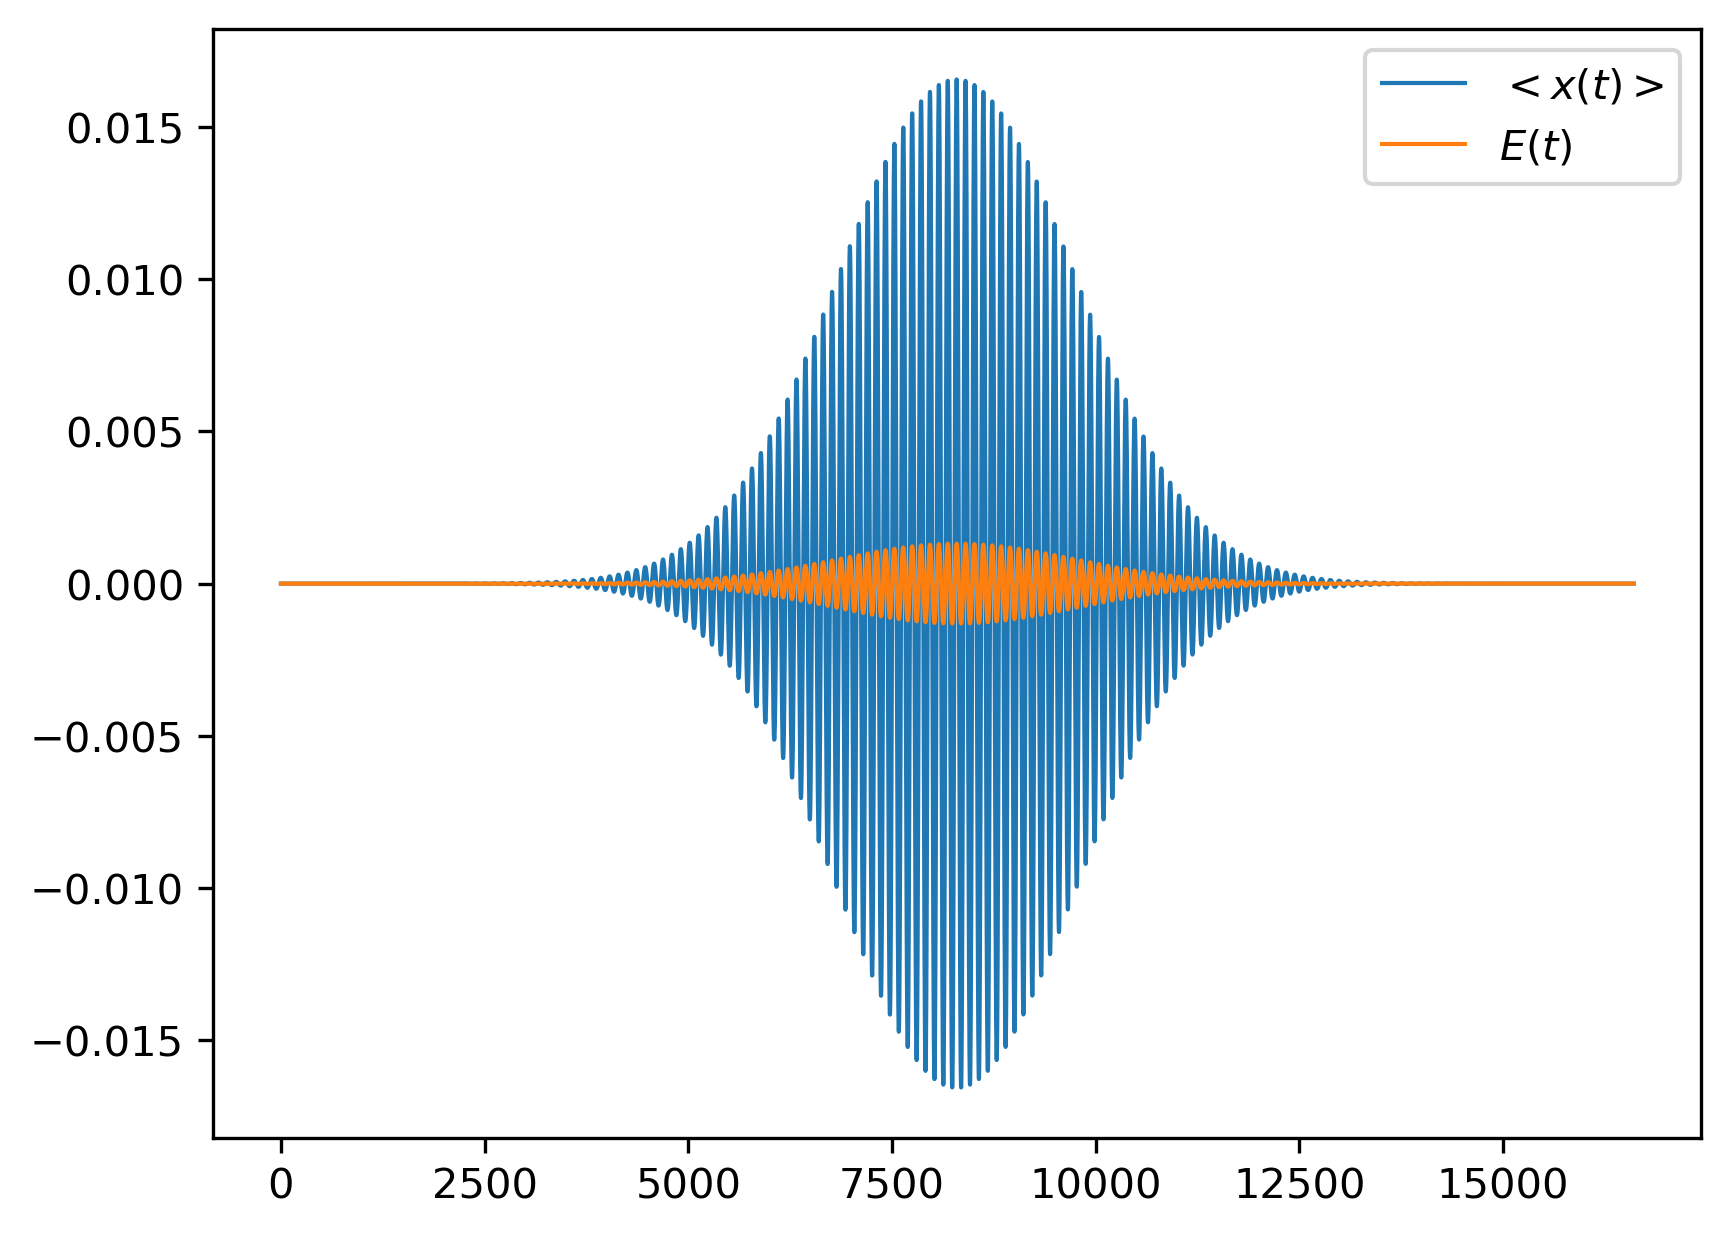

In [10]:
fig = plt.figure()
fig.dpi = 300
N = output.Nt
t = ctype_arr_to_numpy(output.tgrid, N)
x = ctype_arr_to_numpy(output.expval, N)
E = ctype_arr_to_numpy(output.Efield, N)
plt.plot(t, x, label = r"$<x(t)>$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1)
plt.legend()
plt.show()

### Custom field

We show an example how to run the 1D-TDSE with custom numerical electric provided by the Python high level API.

In [11]:
### Create instance of input structure
inputs2 = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs2.init_default_inputs()


Custom field definition and plot

In [12]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs2.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


Plot the chirped pulse

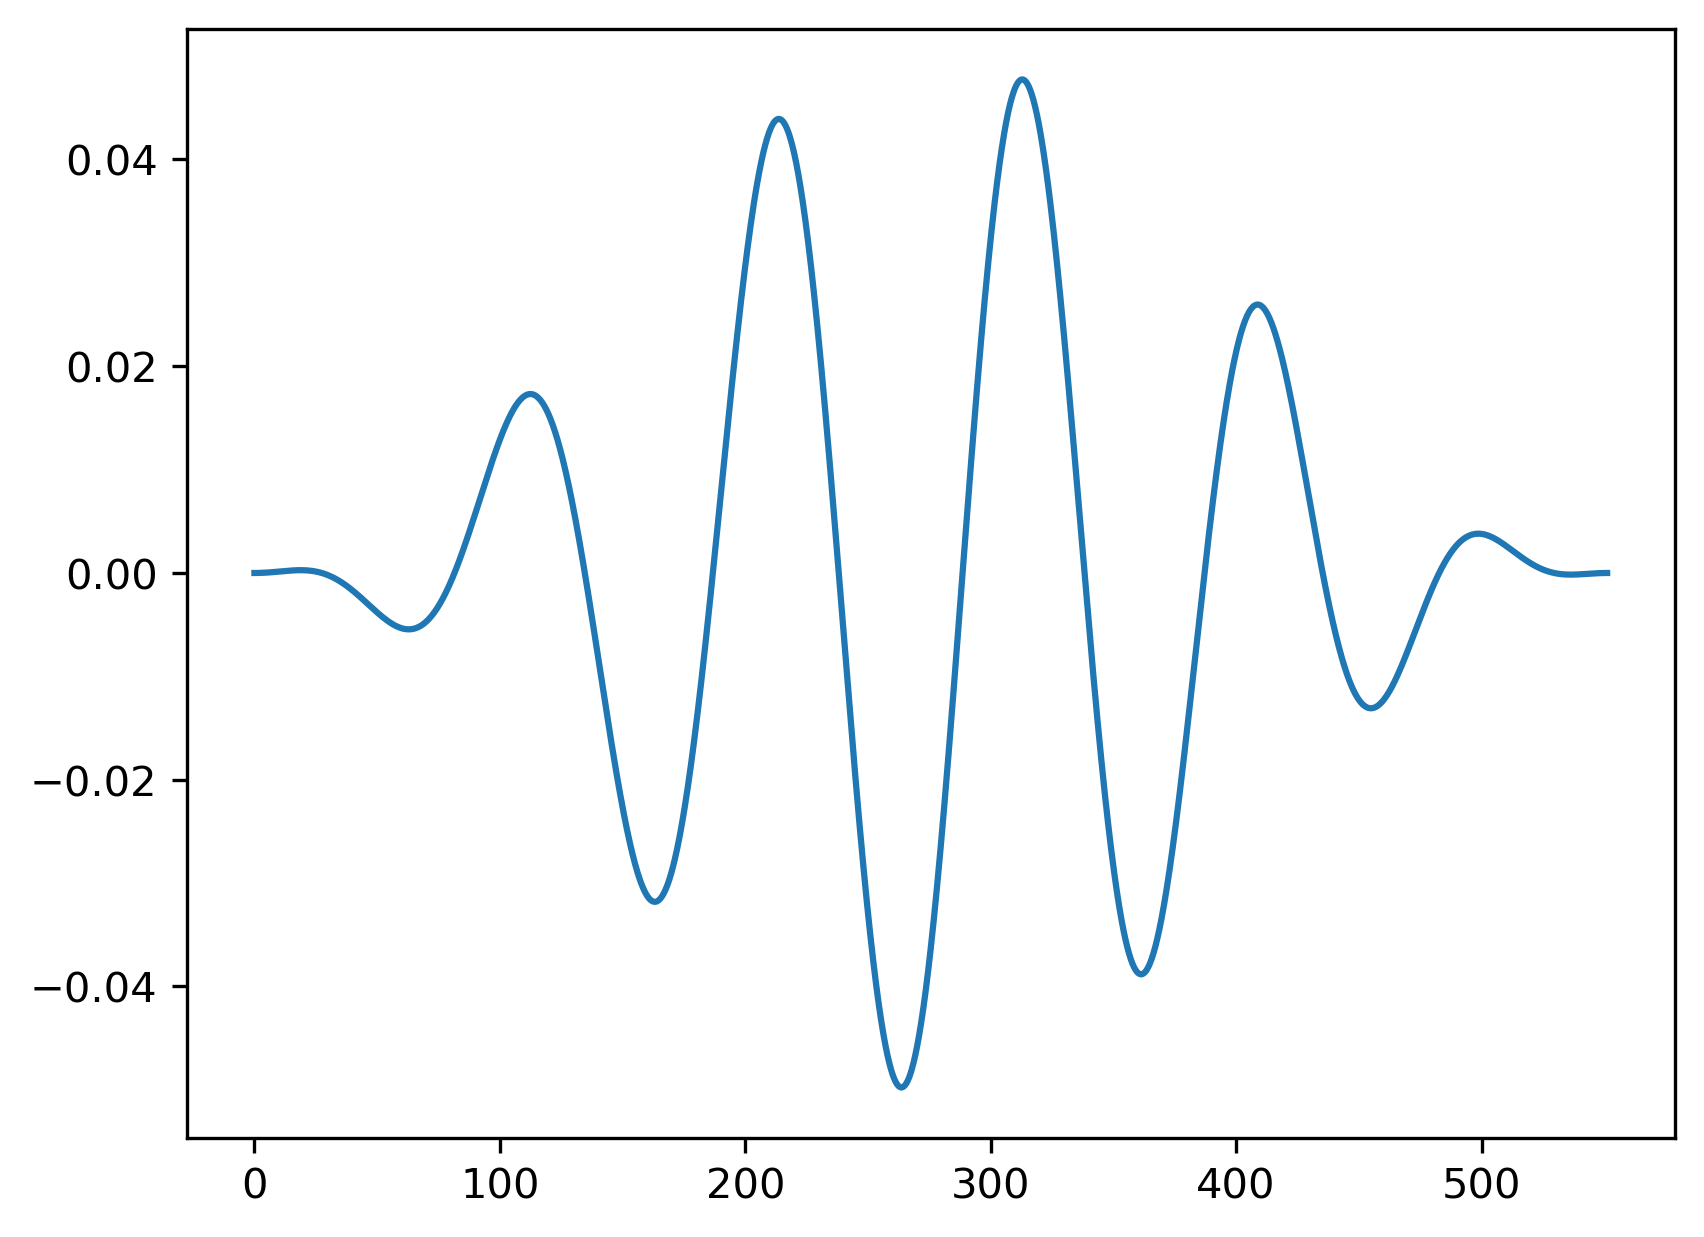

In [13]:
fig = plt.figure()
plt.plot(t, E)
fig.dpi = 300
plt.show()

In [14]:
inputs2.init_time_and_field(path_to_DLL, E = E, t = t)

Compute the GS

In [15]:
DLL.init_GS(inputs2)

Again check the GS

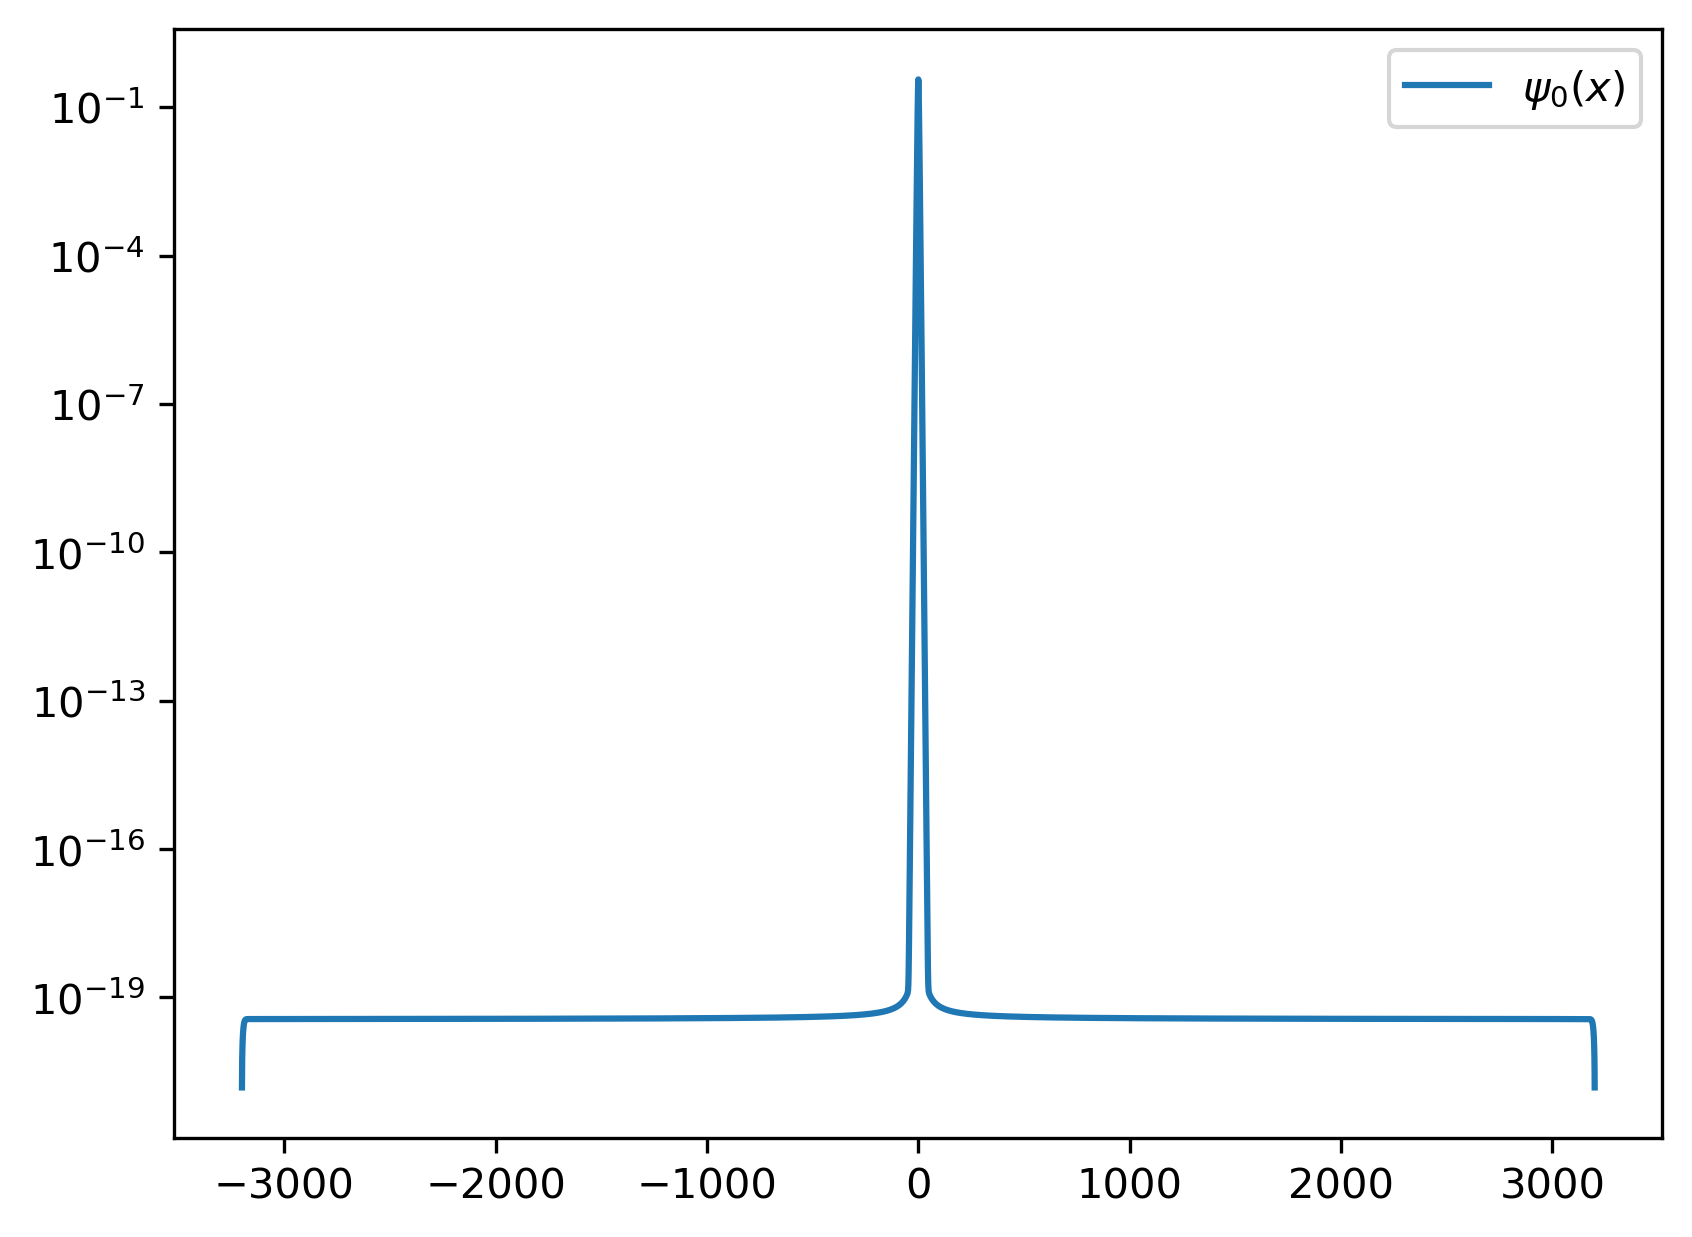

In [16]:
fig = plt.figure()
fig.dpi = 300
psi0 = ctype_arr_to_numpy(inputs2.psi0, 2*(inputs2.num_r+1))
x = ctype_arr_to_numpy(inputs2.x, inputs2.num_r+1)
plt.semilogy(x, np.abs(psi0)[0:-1:2], label = r"$\psi_0(x)$")
plt.legend()
plt.show()

Propagate the field

In [18]:
output2 = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs2, output2)

Nt in TDSE:  4412


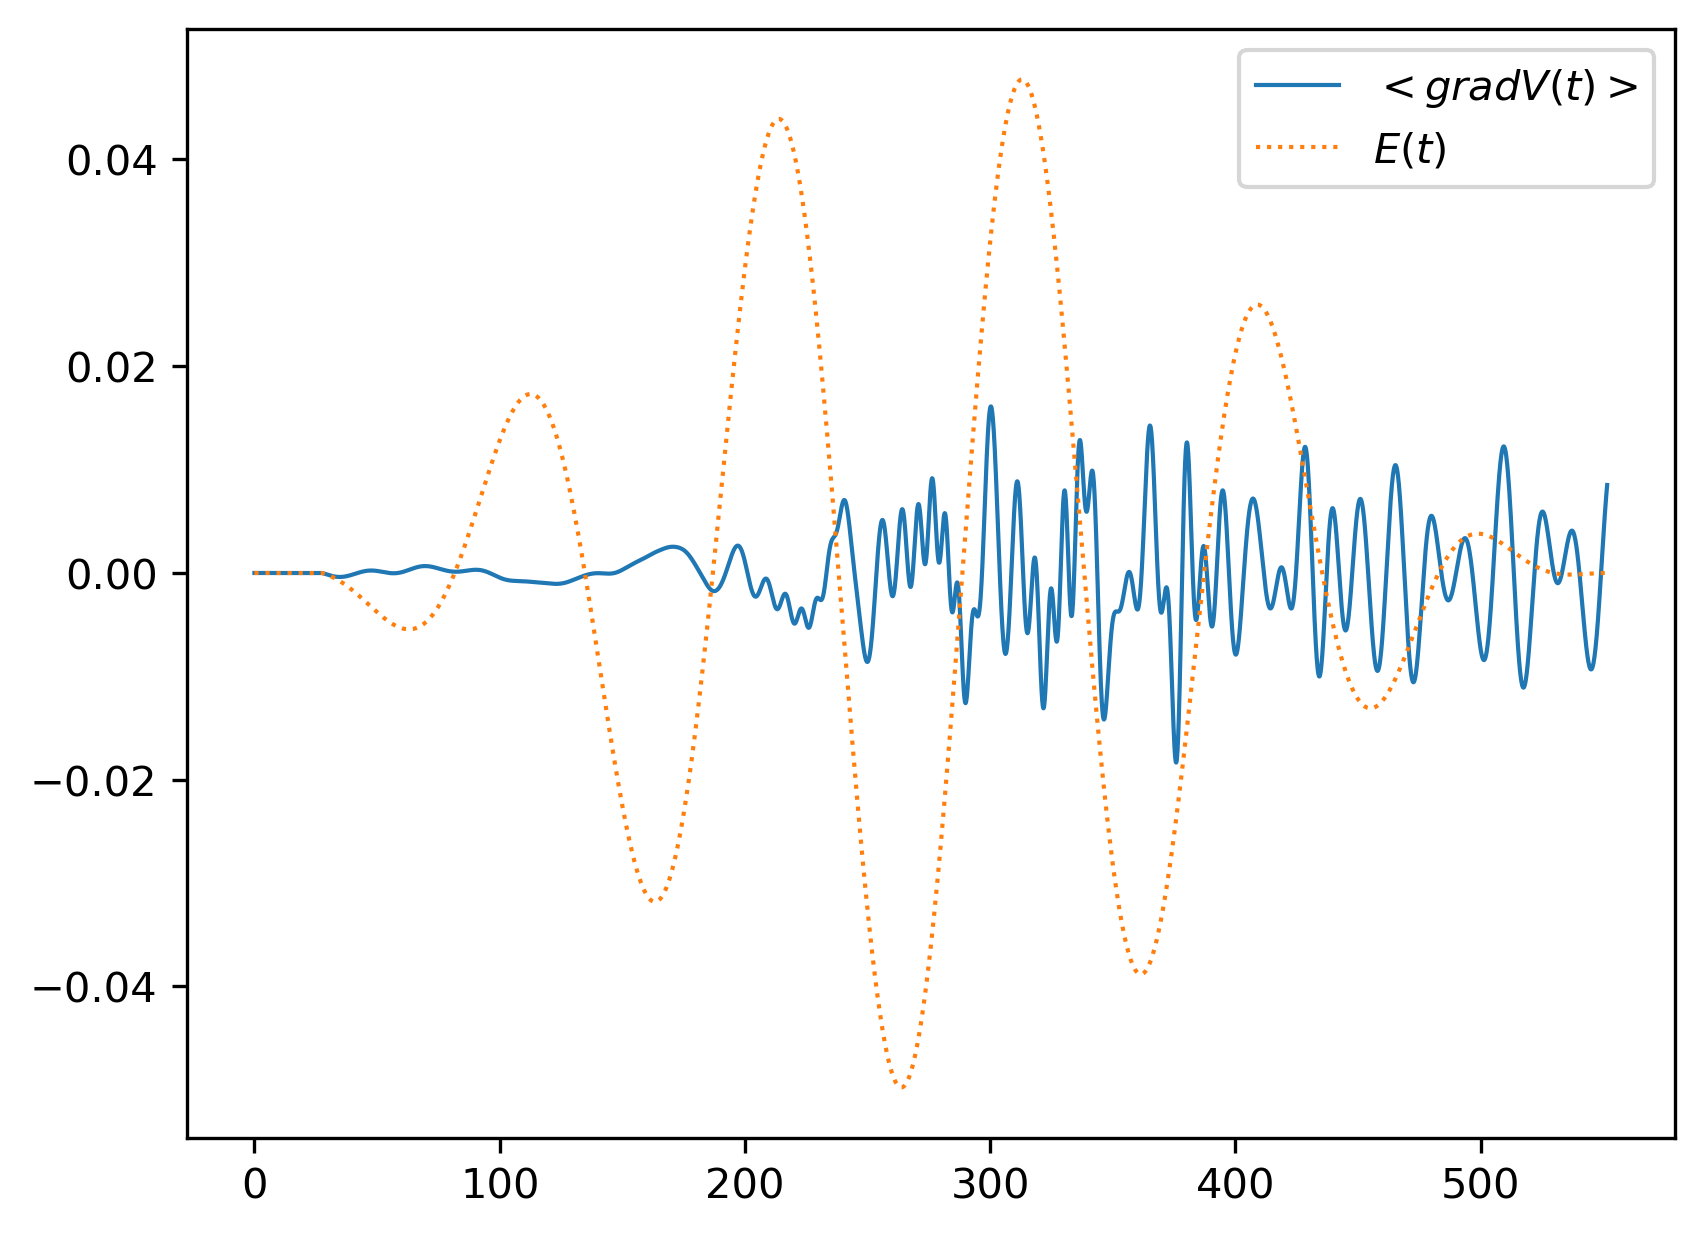

In [19]:
fig = plt.figure()
fig.dpi = 300
N = output2.Nt
print("Nt in TDSE: ", N)
t = ctype_arr_to_numpy(output2.tgrid, N)
x = ctype_arr_to_numpy(output2.sourceterm, N)
E = ctype_arr_to_numpy(output2.Efield, N)
plt.plot(t, x, label = r"$<grad V(t)>$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1, linestyle = ":")
plt.legend()
plt.show()

Check the spectrum of the source term computed in CTDSE using FFTW and Numpy FFT. The FFT is normalized by a factor $dt/\sqrt{2 \pi}$.

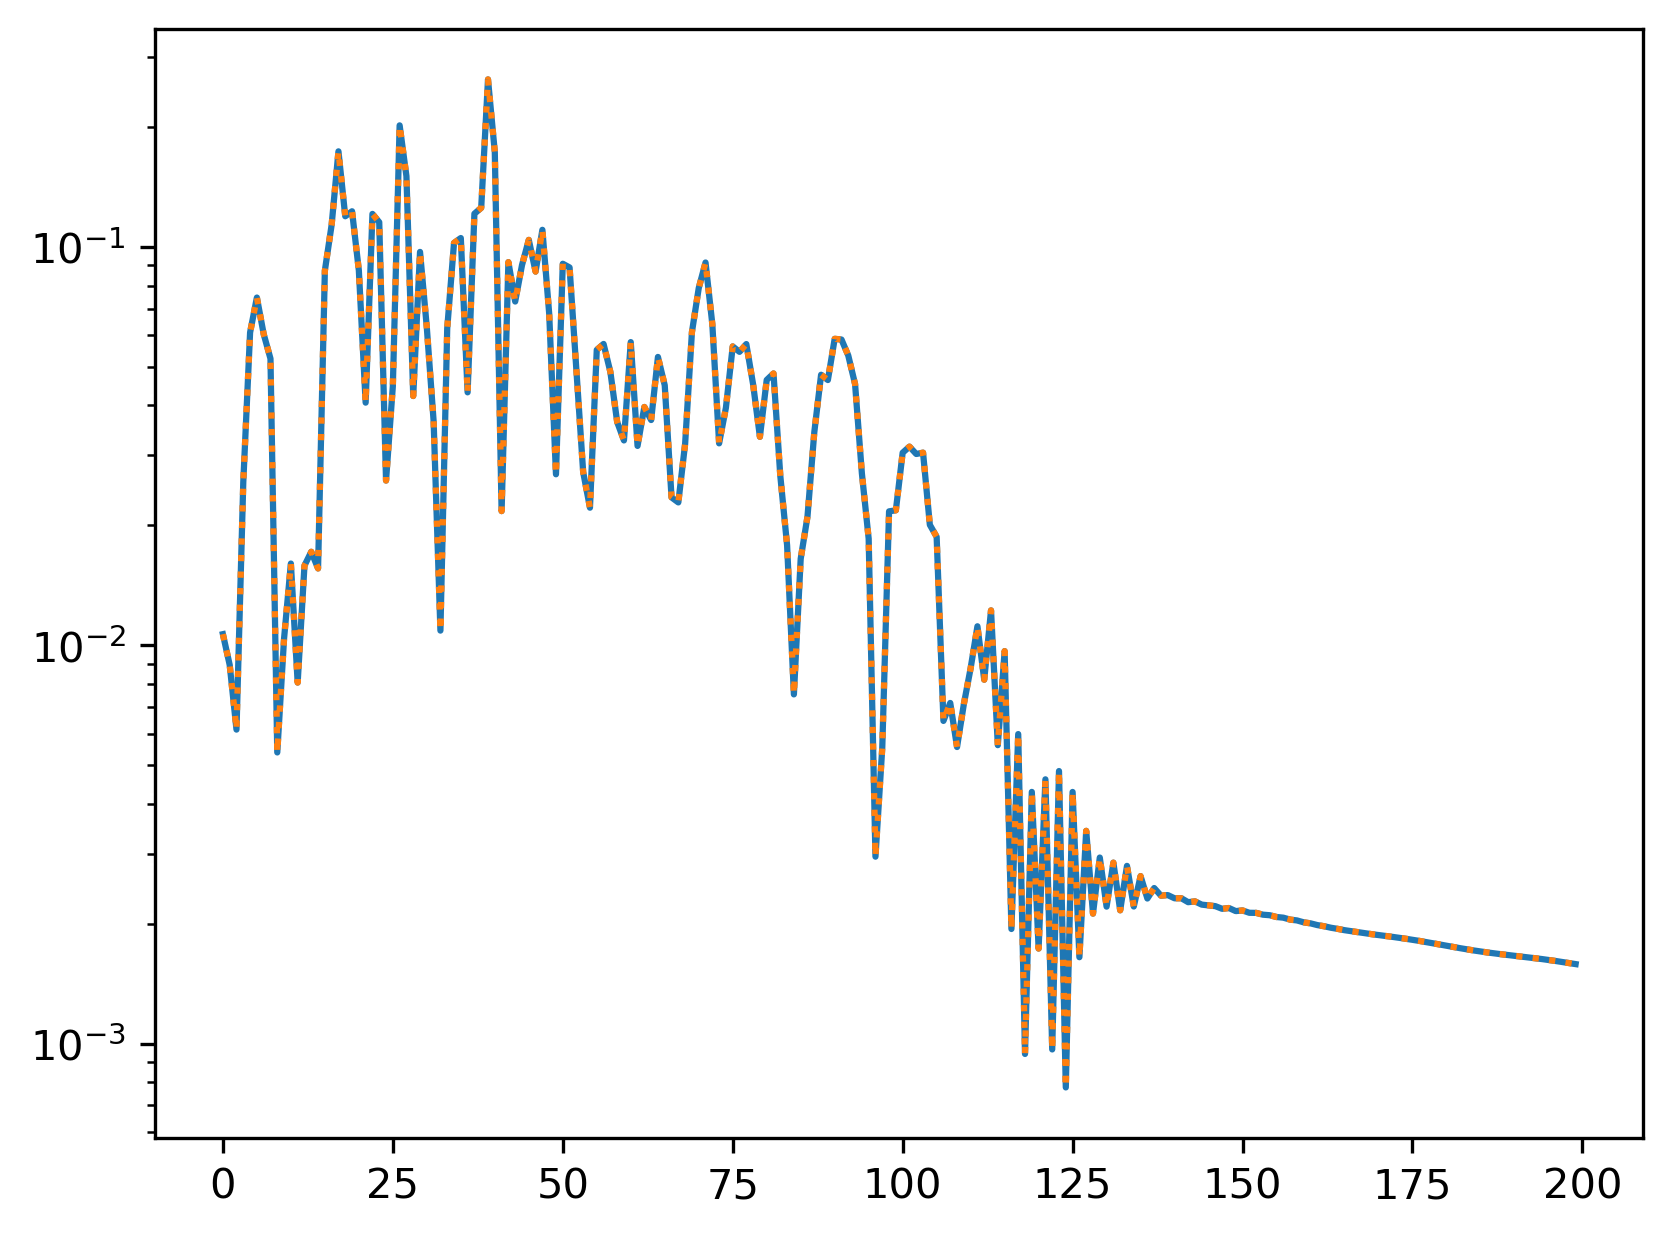

In [20]:
fig = plt.figure()
fig.dpi = 300
plt.semilogy(np.abs(np.fft.fft(x))[0:200]*(t[1]-t[0])/np.sqrt(2*np.pi))
plt.semilogy(np.abs(ctype_cmplx_arr_to_numpy(output2.Fsourceterm_data, N))[0:200], linestyle = ":")
plt.show()

### Plot wavefunction in $t$

In [2]:
### Create instance of input structure
inputs3 = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs3.init_default_inputs()

Set writing and the timestep for wavefunction writing

In [3]:
### Set writing true
inputs3.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs3.analy.tprint = c_double(10.)

In [4]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs3.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


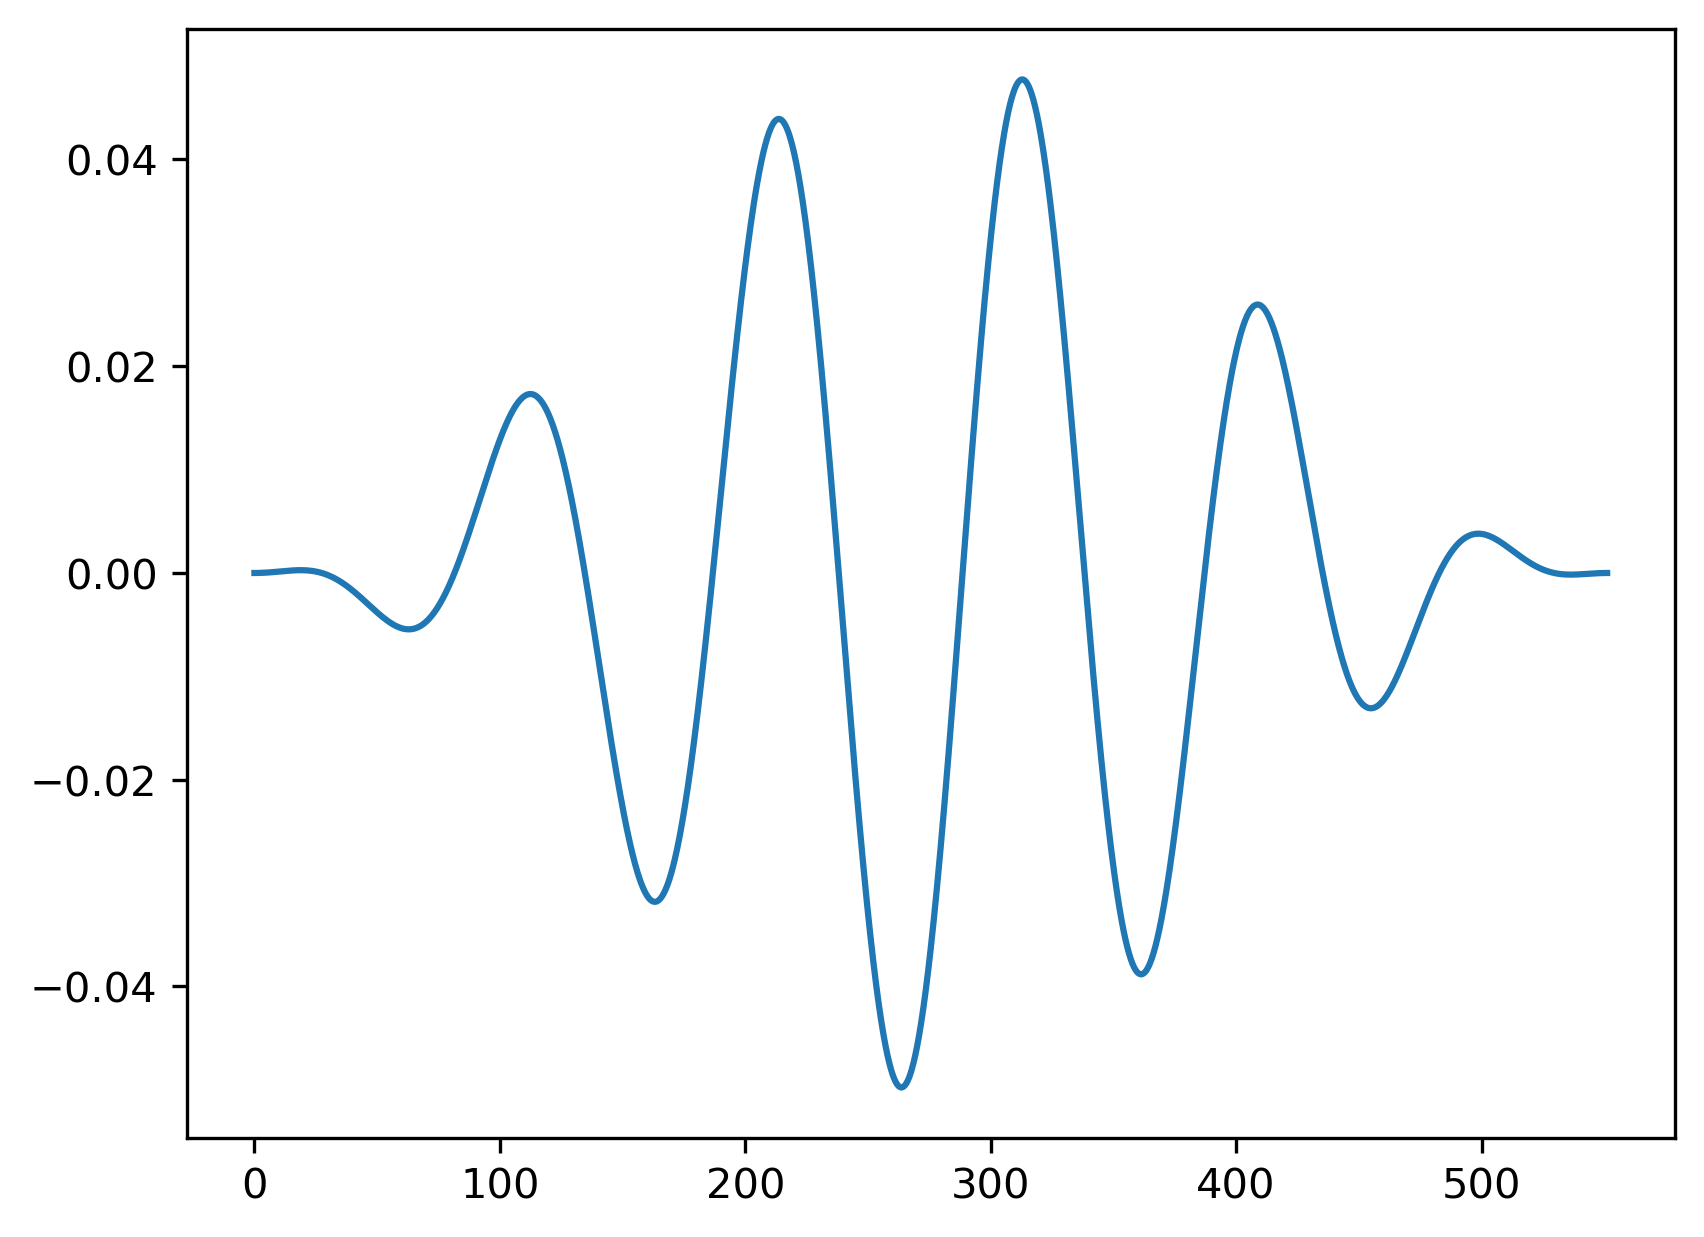

In [5]:
fig = plt.figure()
plt.plot(t, E)
fig.dpi = 300
plt.show()

In [6]:
inputs3.init_time_and_field(path_to_DLL, E = E, t = t)
DLL.init_GS(inputs3)

Call 1DTDSE and write the wavefunction

In [7]:
output3 = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs3, output3)

Set the size of the wavefunction array

In [8]:
### Number of steps per dt for printing in the temporal grid
steps_per_dt = np.floor(inputs3.analy.tprint/(output3.tgrid[1]-output3.tgrid[0]))
### Number of wavefunctions in the final grid
size = int(output3.Nt/steps_per_dt)

print("Number of steps for the wavefunction: ", size)

Number of steps for the wavefunction:  56


Load the wavefunction. We get a complex NDarray.

In [9]:
### Load numpy array from the wavefunction, given the number of wavefunctions
### and given the size of the array for 1 wavefunction
wavefunction = get_wavefunction(output3.psi, size, inputs3.num_r+1)
print("Wavefunction size: ", wavefunction.shape)

Wavefunction size:  (56, 16001)


Prepare temporal and spatial grids from the inputs and outputs.

In [10]:
tgrid = np.linspace(output3.tgrid[0], output3.tgrid[output3.Nt-1], size)
x = np.linspace(-inputs3.dx*inputs3.num_r/2, inputs3.dx*inputs3.num_r/2, inputs3.num_r+1)

Select plotting range along $x$-axis:

In [11]:
x_range = (np.abs(x) < 1000.1)

Plot colormap of the wavefunction evolution (absolute value of $\psi$).

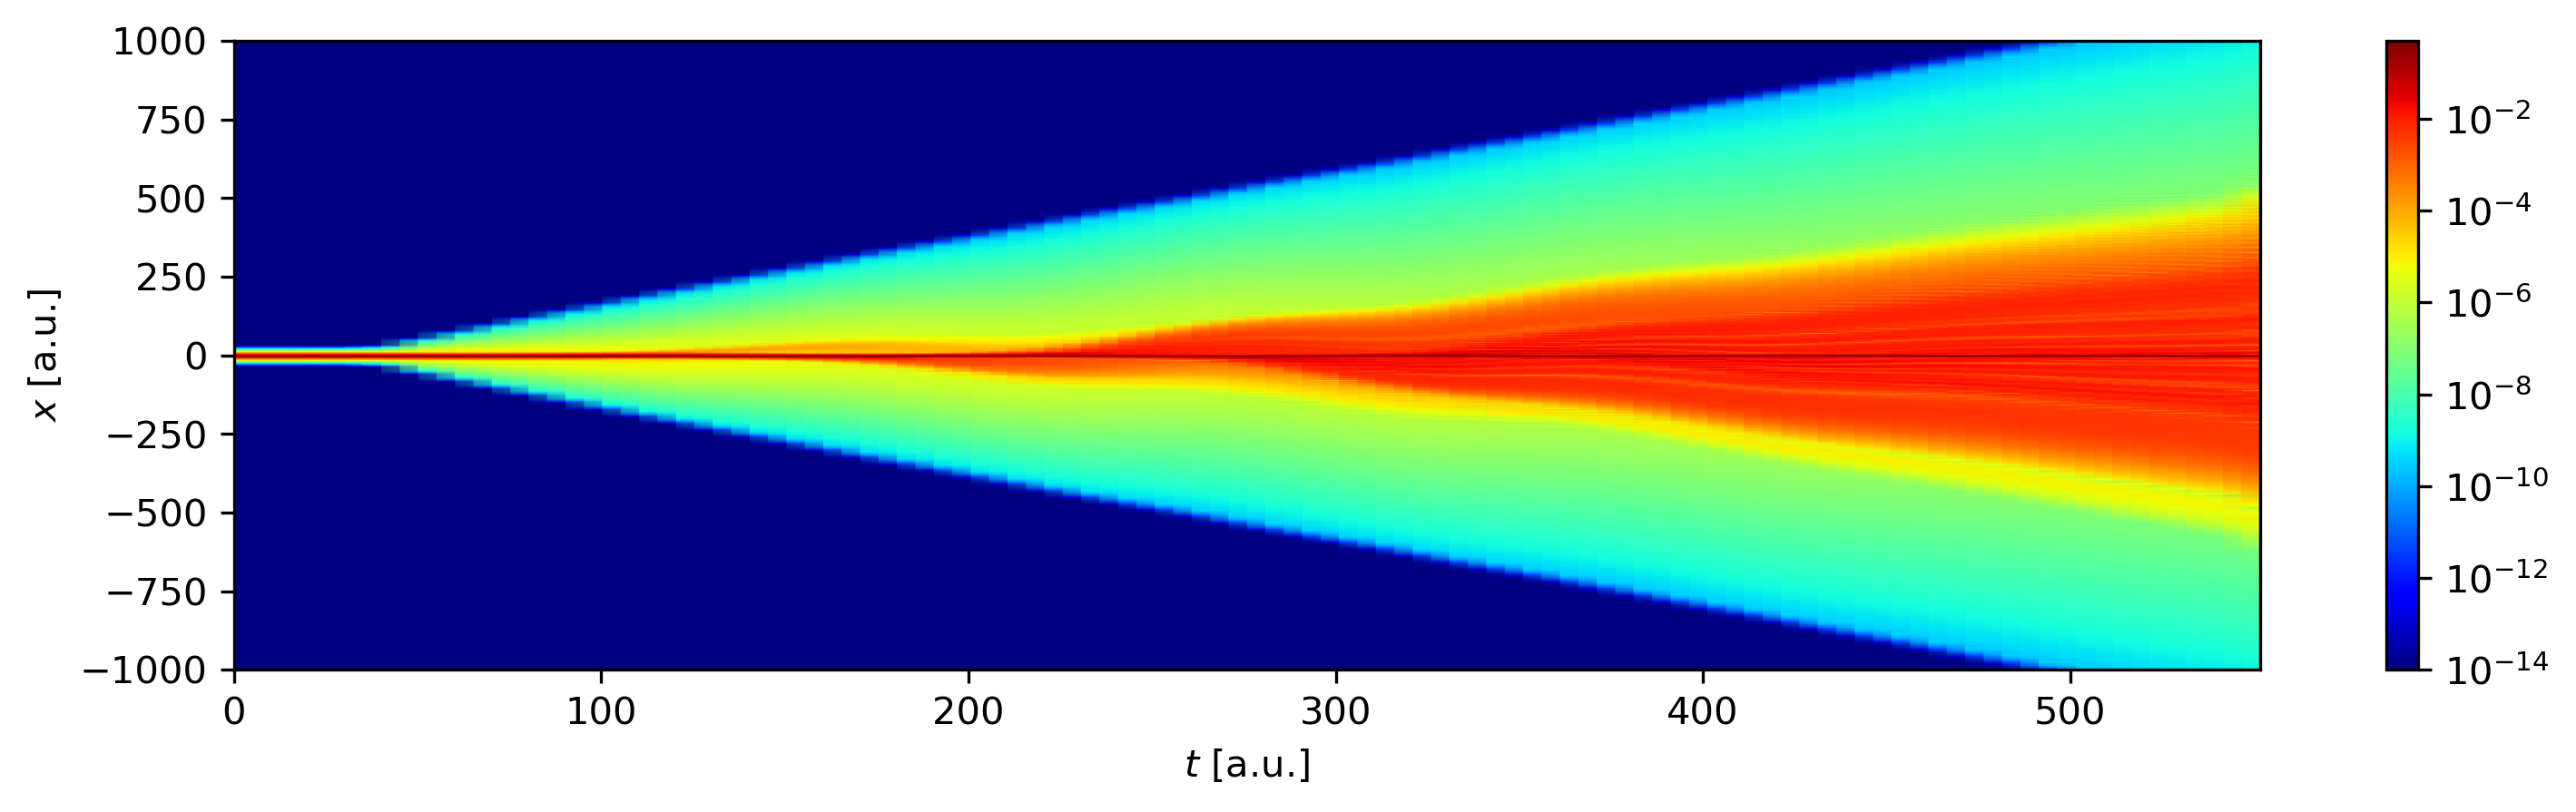

In [12]:
plot_colormap(x[x_range], tgrid, np.transpose(np.abs(wavefunction))[x_range], x_label=r"$t$ [a.u.]", y_label=r"$x$ [a.u.]", plot_scale="log", z_max=0.5)

Plot final wavefunction $\psi(t = T)$

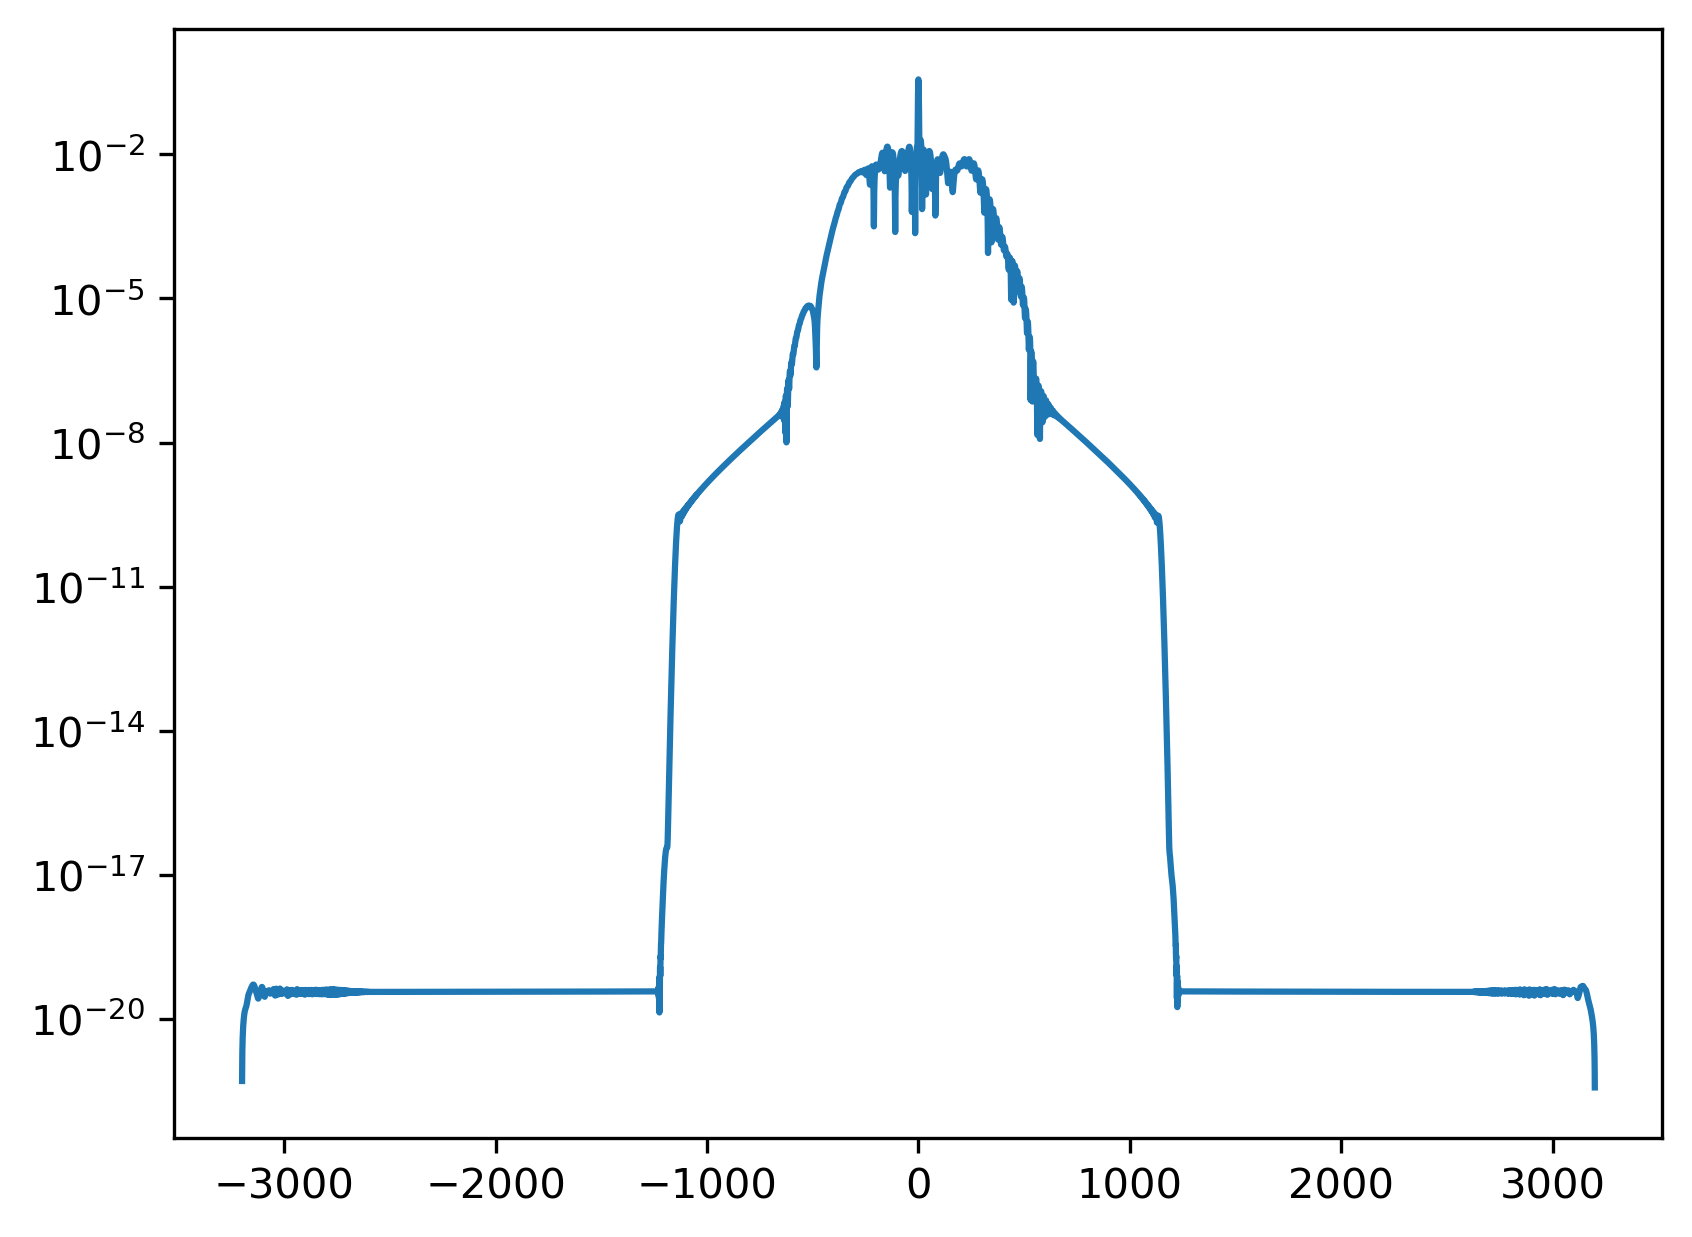

In [13]:
fig = plt.figure()
fig.dpi = 300
psi = wavefunction[-1]
plt.semilogy(x, np.abs(psi))
plt.show()

### Computing photoelectron spectrum (PES) for the final $\psi$

Save the final wavefunction pointer

In [14]:
### Setting final wavefunction for the PES computation
psi_final = output3.psi[size-1]

Compute PSE using the wrapper function, provided input structure and $\psi(t = T)$.

In [15]:
E, PSE = DLL.compute_PES(inputs3, psi_final)

Plotting PES

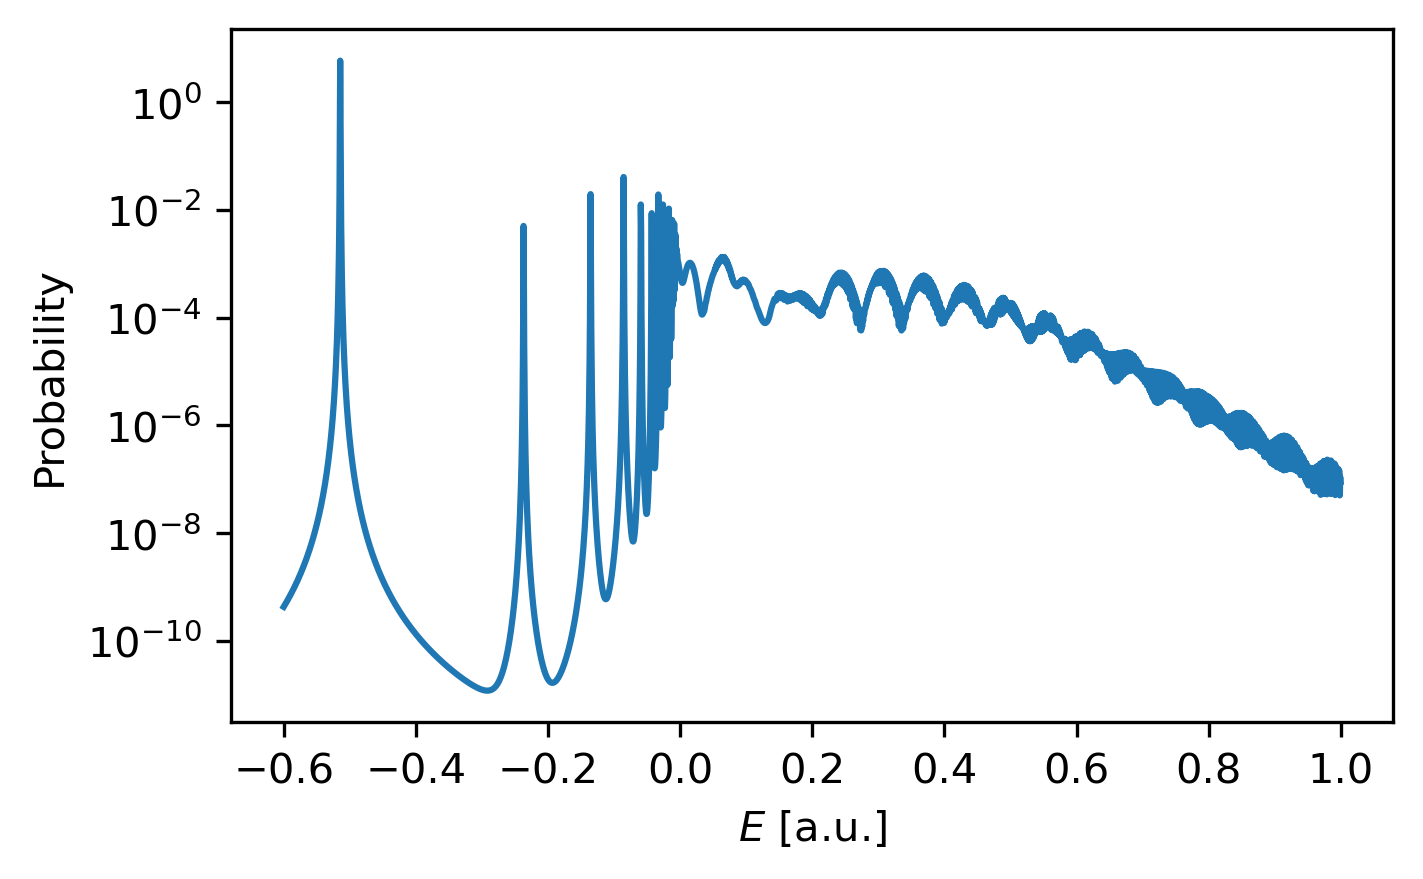

In [16]:
### Set range for plotting PES below 1 a.u. of energy
E_range = (E < 1.)

### Do the plot
plot((E[E_range]), PSE[E_range], y_label="Probability", x_label=r"$E$ [a.u.]", plot_scale="log")

Free wavefunction in the outputs.

In [17]:
DLL.free_mtrx(output3.psi, size)

### Print Gabor transform of $<\nabla V>$

In [21]:
grad_V = output3.sourceterm
dt = output3.tgrid[1]-output3.tgrid[0]
Nt = output3.Nt
omega_0 = 0.057
omega_max = omega_0*35
T = output3.tgrid[Nt-1]

In [24]:
t, omegas, gabor = DLL.gabor_transform(grad_V, dt, Nt, omega_max, 100., 400, 1000, a=8)

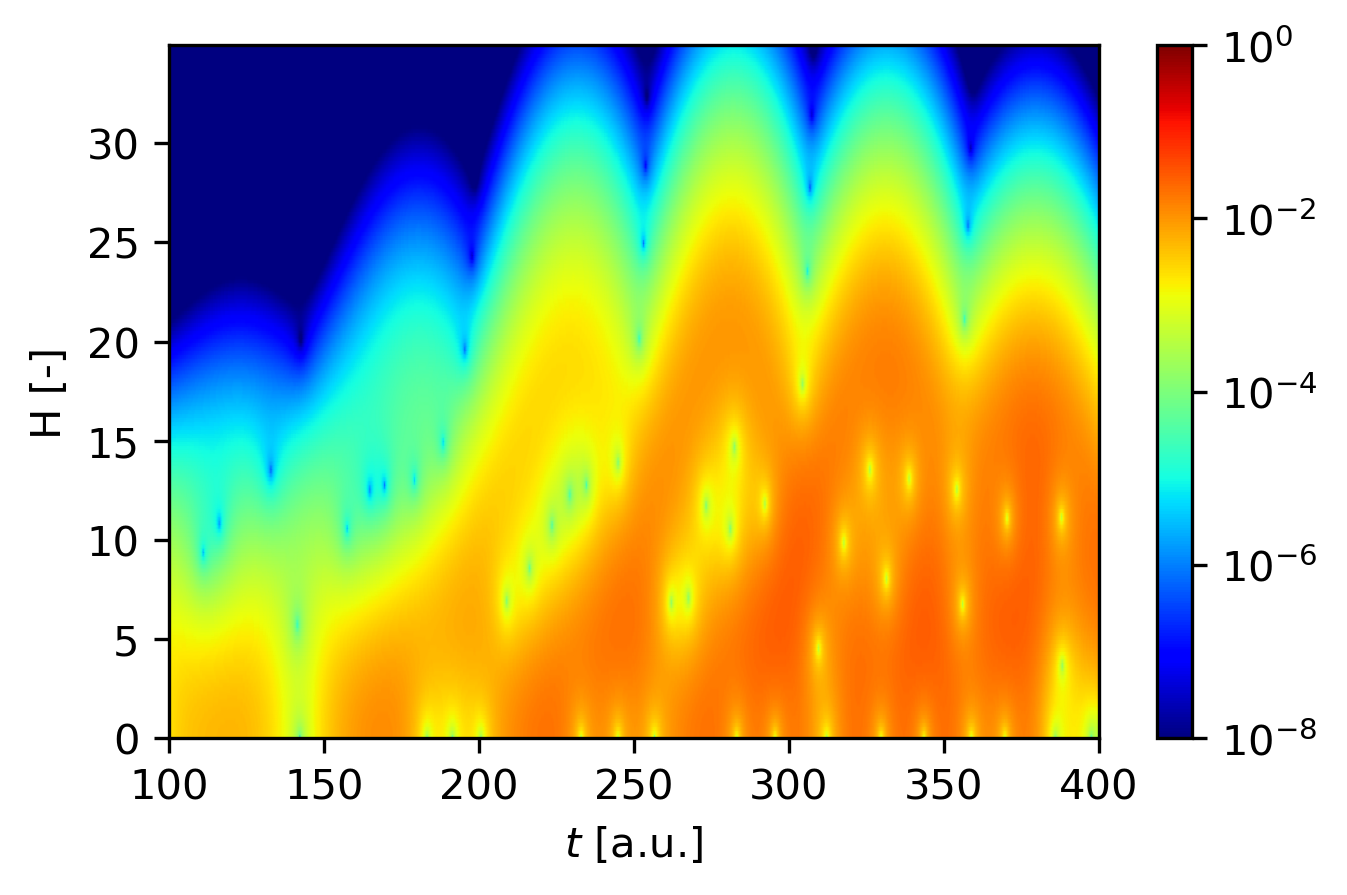

In [28]:
plot_colormap(omegas/omega_0, t, gabor, z_min=1e-8, figsize=(5, 3), x_label=r"$t$ [a.u.]", y_label=r"H [-]")

## Free memory

The structures should be released after the termination of the Python kernel. We can free the memory using ```delete(DLL)``` methods of ```inputs_def``` and ```outputs_def``` structures.

We must provide the DLL class for the C wrapper.

In [29]:
inputs.delete(DLL)
inputs2.delete(DLL)
inputs3.delete(DLL)

In [30]:
output.delete(DLL)
output2.delete(DLL)
output3.delete(DLL)